# Locate People and Objects

This notebook is part of [Lab 3](https://github.com/ee292d/labs/blob/main/lab3/README.md), which focuses on locating objects within an image, for the [EE292D Edge ML class](https://ee292d.github.io/) at Stanford. It shows how to download some pretrained models for person and object detection.

If you're not already in Google's Colab environment (or another notebook client) [click here to open it in Colab](https://colab.research.google.com/github/ee292d/labs/blob/main/lab3/notebook.ipynb).

## Install Ultralytics

We used [Ultralytics](https://github.com/ultralytics/ultralytics) for [Lab 2](https://github.com/ee292d/labs/blob/main/lab2/README.md), and since the project also offers some very efficient models for finding where objects are in a scene, we'll install it in this notebook too.

In [1]:
%pip install ultralytics

import ultralytics
ultralytics.checks()

Ultralytics YOLOv8.1.42 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Setup complete ✅ (8 CPUs, 51.0 GB RAM, 29.1/201.2 GB disk)


## Download and Run a Detection Model

In computer vision, the task of finding the locations of objects in a scene is known as "detection", which is different than the "classification" of images that we performed in the previous lab.

To understand the difference, "*Does this image contain a hot dog?*" is a classification question, but "*Does this image contain any hot dogs, and where are they?*" is detection. As you might imagine, detection is a harder task than classification, and understanding the output of the model is also more complicated.

Thankfully the Ultralytics team have created some classification models that offer good tradeoffs between accuracy and latency. We'll download one of them and run it on a test image.

In [2]:
from ultralytics import YOLO

model = YOLO("yolov8n.pt")
results = model('https://ultralytics.com/images/bus.jpg')
print(results[0].boxes)

100%|██████████| 6.23M/6.23M [00:00<00:00, 171MB/s]


100%|██████████| 476k/476k [00:00<00:00, 32.5MB/s]


image 1/1 /content/bus.jpg: 640x480 4 persons, 1 bus, 1 stop sign, 136.9ms
Speed: 17.9ms preprocess, 136.9ms inference, 753.9ms postprocess per image at shape (1, 3, 640, 480)
ultralytics.engine.results.Boxes object with attributes:

cls: tensor([ 5.,  0.,  0.,  0., 11.,  0.], device='cuda:0')
conf: tensor([0.8705, 0.8690, 0.8536, 0.8193, 0.3461, 0.3013], device='cuda:0')
data: tensor([[1.7286e+01, 2.3059e+02, 8.0152e+02, 7.6841e+02, 8.7054e-01, 5.0000e+00],
        [4.8739e+01, 3.9926e+02, 2.4450e+02, 9.0250e+02, 8.6898e-01, 0.0000e+00],
        [6.7027e+02, 3.8028e+02, 8.0986e+02, 8.7569e+02, 8.5360e-01, 0.0000e+00],
        [2.2139e+02, 4.0579e+02, 3.4472e+02, 8.5739e+02, 8.1931e-01, 0.0000e+00],
        [6.4347e-02, 2.5464e+02, 3.2288e+01, 3.2504e+02, 3.4607e-01, 1.1000e+01],
        [0.0000e+00, 5.5101e+02, 6.7105e+01, 8.7394e+02, 3.0129e-01, 0.0000e+00]], device='cuda:0')
id: None
is_track: False
orig_shape: (1080, 810)
shape: torch.Size([6, 6])
xywh: tensor([[409.4020, 499.4990,

This gives us the numerical information about the object names, scores, and locations, but it's not easy to make sense in this form. To help, we can plot the results on the original image.

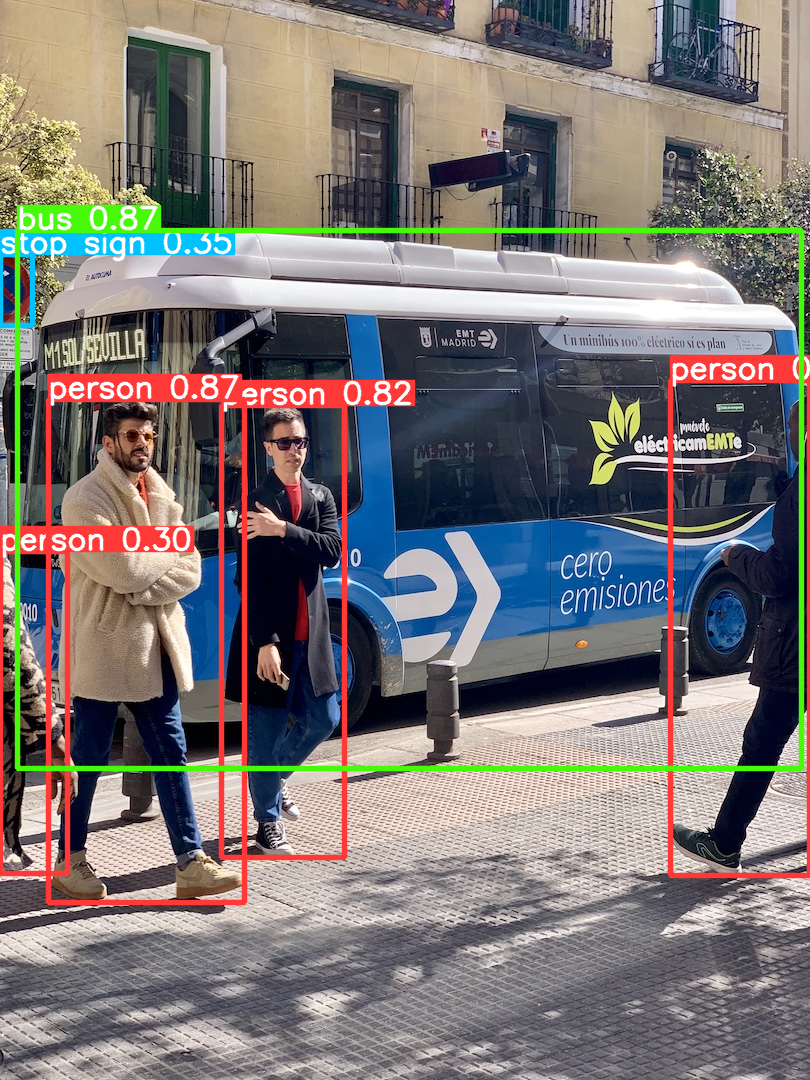

In [3]:
from PIL import Image as im

# We need to switch from BGR to RGB channel order.
bgr_array = results[0].plot()
rgb_array = bgr_array[:, :, ::-1]

im.fromarray(rgb_array)

## Exporting to TensorFlow Lite

We want to run this model as fast as possible on our Raspberry Pi, and TensorFlow Lite offers an efficient inference framework designed for phones and boards like the Pi. We do need to export it from the Ultralytics format into a file TF Lite can understand though. As with the classification notebook, we'll do this by running Ultralytics export function targeting TF Lite and 8-bit quantization. The process can take several minutes, and you can expect to see a `StatusCode` error at the end, but that shouldn't affect the overall output since it happens after the files we need are saved.

In [4]:
model.export(format='tflite', int8=True)

Ultralytics YOLOv8.1.42 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'yolov8n.pt' with input shape (1, 3, 640, 640) BCHW and output shape(s) (1, 84, 8400) (6.2 MB)
requirements: Ultralytics requirements ['onnx>=1.12.0', 'onnx2tf>=1.15.4,<=1.17.5', 'sng4onnx>=1.0.1', 'onnxsim>=0.4.33', 'onnx_graphsurgeon>=0.3.26', 'tflite_support', 'onnxruntime-gpu'] not found, attempting AutoUpdate...
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.9/15.9 MB 126.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 400.4/400.4 kB 312.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 MB 246.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.1/42.1 kB 185.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 175.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.1/192.1 MB 187.3 MB/s eta 0:00:00
     ━

100%|██████████| 1.11M/1.11M [00:00<00:00, 45.9MB/s]
Unzipping calibration_image_sample_data_20x128x128x3_float32.npy.zip to /content/calibration_image_sample_data_20x128x128x3_float32.npy...: 100%|██████████| 1/1 [00:00<00:00, 41.58file/s]


ONNX: starting export with onnx 1.16.0 opset 17...


ONNX: simplifying with onnxsim 0.4.36...
ONNX: export success ✅ 1.3s, saved as 'yolov8n.onnx' (12.3 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.17.5...

Automatic generation of each OP name started ========================================
Automatic generation of each OP name complete!

Model loaded ========================================================================

Model conversion started ============================================================
saved_model output started ==========================================================
saved_model output complete!
Float32 tflite output complete!
Float16 tflite output complete!
Input signature information for quantization
signature_name: serving_default
input_name.0: images shape: (1, 640, 640, 3) dtype: <dtype: 'float32'>
Dynamic Range Quantization tflite output complete!
INT8 Quantization tflite output complete!
Full INT8 Quantization tflite output complete!
INT8 Quantization with int16 activations tflite outp

ImportError: generic_type: cannot initialize type "StatusCode": an object with that name is already defined

## Download the Model

After the export has been run, you'll need to find the output file. To do this, open the file explorer from the icon on the left side of the notebook, and navigate to the `yolov8n_saved_model` folder. In there you should see a `yolov8n_in8.tflite` file. Right click on it and select "Download" to save it to your laptop.

Once that's complete, drag it to the `models` folder in your VS Code editor, and then return to the [Lab 3 instructions](https://github.com/ee292d/labs/tree/main/lab3#locate-people-and-objects)
to run it on your board. You'll continue this notebook once you've given that a try.

## Shrink the Input Size

Welcome back from the readme. As you'll have seen on the Pi, the model takes over 400ms to run. A lot of this is because it's processing a 640 pixel by 640 pixel image. If we can convert the model to a smaller input image, we should be able to speed things up dramatically. In this step, we're going to retrain the model to use a 224 pixel square input image.

Thankfully the YOLOv8 model is entirely convolutional, which means it needs minimal training to adapt to a new input image size. In this call we're going to specify the required image size, indicate that we'll use the pretrained weights, freeze most of the layers, and only run one epoch of training on a very small dataset. This will still take a few minutes to complete, but at the end we should have a resized model that retains a lot of the accuracy of the original.

In [20]:
train_results = model.train(data="coco128.yaml", imgsz=224, pretrained=True, freeze=10, epochs=1)
save_dir = train_results.save_dir

Ultralytics YOLOv8.1.42 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
engine/trainer: task=detect, mode=train, model=yolov8n.pt, data=coco128.yaml, epochs=1, time=None, patience=100, batch=16, imgsz=224, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train533, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=10, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_bo

train: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]

albumentations: Blur(p=0.01, blur_limit=(3, 7)), MedianBlur(p=0.01, blur_limit=(3, 7)), ToGray(p=0.01), CLAHE(p=0.01, clip_limit=(1, 4.0), tile_grid_size=(8, 8))



val: Scanning /content/datasets/coco128/labels/train2017.cache... 126 images, 2 backgrounds, 0 corrupt: 100%|██████████| 128/128 [00:00<?, ?it/s]


Plotting labels to runs/detect/train533/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000119, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added ✅
Image sizes 224 train, 224 val
Using 8 dataloader workers
Logging results to runs/detect/train533
Starting training for 1 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


        1/1     0.782G       1.25      1.187      1.121         95        224: 100%|██████████| 8/8 [00:02<00:00,  2.95it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.24s/it]


                   all        128        929      0.653      0.486      0.525      0.389

1 epochs completed in 0.005 hours.
Optimizer stripped from runs/detect/train533/weights/last.pt, 6.5MB
Optimizer stripped from runs/detect/train533/weights/best.pt, 6.5MB

Validating runs/detect/train533/weights/best.pt...
Ultralytics YOLOv8.1.42 🚀 Python-3.10.12 torch-2.2.1+cu121 CUDA:0 (Tesla V100-SXM2-16GB, 16151MiB)
Model summary (fused): 168 layers, 3151904 parameters, 0 gradients, 8.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 4/4 [00:04<00:00,  1.21s/it]


                   all        128        929      0.652      0.501      0.524       0.39
                person        128        254      0.701      0.512      0.551      0.373
               bicycle        128          6      0.548      0.167      0.167      0.167
                   car        128         46      0.719      0.109      0.102     0.0758
            motorcycle        128          5       0.83      0.977      0.962      0.872
              airplane        128          6      0.658          1      0.942      0.775
                   bus        128          7      0.674      0.593      0.679      0.616
                 train        128          3       0.54          1      0.995      0.913
                 truck        128         12      0.933      0.333       0.35      0.216
                  boat        128          6      0.382      0.623      0.501      0.315
         traffic light        128         14      0.712      0.143      0.148      0.104
             stop sig

## Test the Small Model

We'll run a sanity check here to make sure that the model we've retrained still works as expected. You'll see an image plotting the results below, and it should be very similar to the output of the original model, apart from missing one partial person on the right of the frame.

If this works, then we're ready to export the new model.


Found https://ultralytics.com/images/bus.jpg locally at bus.jpg
image 1/1 /content/bus.jpg: 224x192 3 persons, 1 bus, 15.9ms
Speed: 0.8ms preprocess, 15.9ms inference, 1.7ms postprocess per image at shape (1, 3, 224, 192)


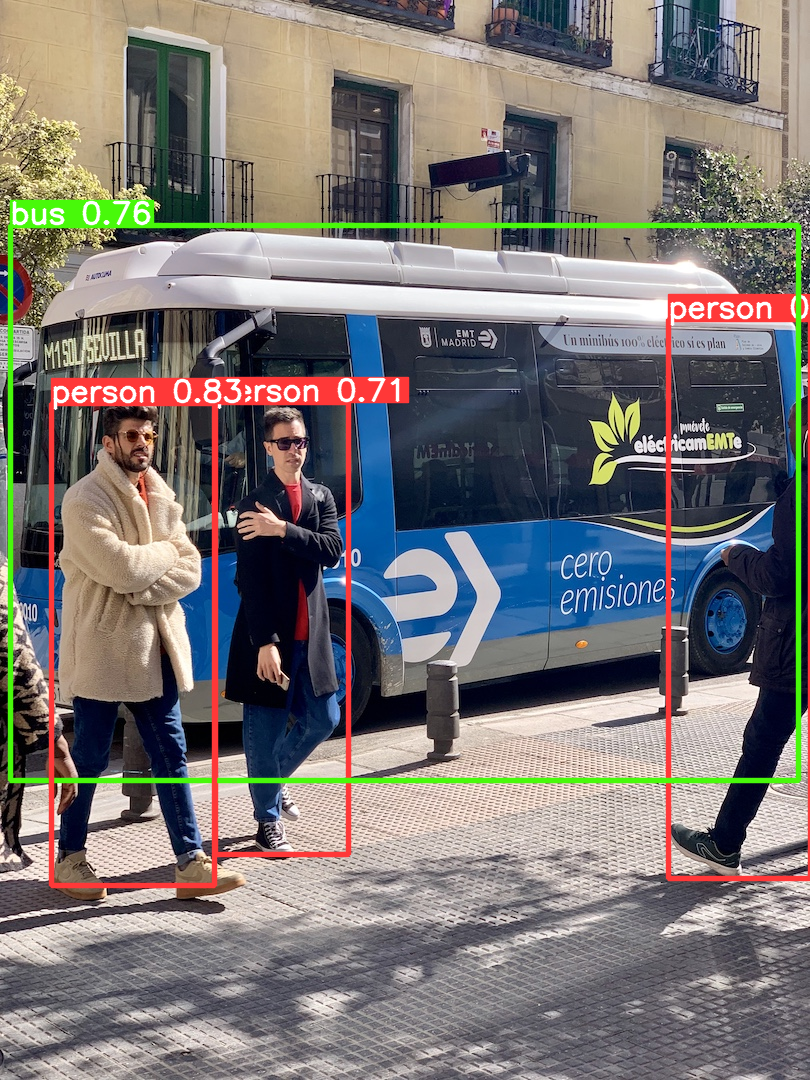

In [17]:
smaller_model = YOLO(str(save_dir) + "/weights/best.pt")
results = smaller_model('https://ultralytics.com/images/bus.jpg')

bgr_array = results[0].plot()
rgb_array = bgr_array[:, :, ::-1]
im.fromarray(rgb_array)

## Export the Small Model

We'll use the same approach we did above to save out the TF Lite version of the model.

In [18]:
smaller_model.export(format='tflite', int8=True)

Ultralytics YOLOv8.1.42 🚀 Python-3.10.12 torch-2.2.1+cu121 CPU (Intel Xeon 2.00GHz)

PyTorch: starting from 'runs/detect/train53/weights/best.pt' with input shape (1, 3, 224, 224) BCHW and output shape(s) (1, 84, 1029) (6.2 MB)

TensorFlow SavedModel: starting export with tensorflow 2.15.0...
WARNING ⚠️ tensorflow<=2.13.1 is required, but tensorflow==2.15.0 is currently installed https://github.com/ultralytics/ultralytics/issues/5161

ONNX: starting export with onnx 1.16.0 opset 17...
ONNX: simplifying with onnxsim 0.4.36...
ONNX: export success ✅ 1.5s, saved as 'runs/detect/train53/weights/best.onnx' (12.1 MB)
TensorFlow SavedModel: starting TFLite export with onnx2tf 1.17.5...

Automatic generation of each OP name started ========================================
Automatic generation of each OP name complete!

Model loaded ========================================================================

Model conversion started ============================================================
save

ImportError: generic_type: cannot initialize type "StatusCode": an object with that name is already defined

## Download the Small Model

You'll need to locate the `best_int8.tflite` model

